In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import scatter_matrix
import warnings
from sys import modules
import seaborn as sns


warnings.filterwarnings('ignore')
%matplotlib inline

The most intuitive classification algorithm is called [k-nearest neighbors][knn], and in its simplest form it performs a "voting" among the k nearest neighbors of the data point to be classified. Its basic parameter is _k_ (the _n_\__neighbors_ argument), and as illustrated by the figure below, this algorithm tends to be "unstable" for small values of _k_.

[knn]: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm "kNN - Wikipedia"

# Illustrative example

In this example we will classify one of the classical datasets in the ML world - [The **_iris_** dataset][iris]. 

[iris]: https://en.wikipedia.org/wiki/Iris_flower_data_set "The iris dataset - Wikipedia"

## The _iris_ dataset

In [2]:
if 'google.colab' in modules:
    from google.colab import files
    uploaded = files.upload()

Saving iris.csv to iris.csv


In [4]:
iris = pd.read_csv('iris.csv', index_col=0)
iris.sample(10)

,sepal length,sepal width,petal length,petal width,Type
9,4.9,3.1,1.5,0.1,setosa
128,6.4,2.8,5.6,2.1,virginica
147,6.5,3.0,5.2,2.0,virginica
46,5.1,3.8,1.6,0.2,setosa
33,5.5,4.2,1.4,0.2,setosa
7,5.0,3.4,1.5,0.2,setosa
140,6.7,3.1,5.6,2.4,virginica
117,7.7,3.8,6.7,2.2,virginica
17,5.1,3.5,1.4,0.3,setosa
133,6.3,2.8,5.1,1.5,virginica


**Visualization**

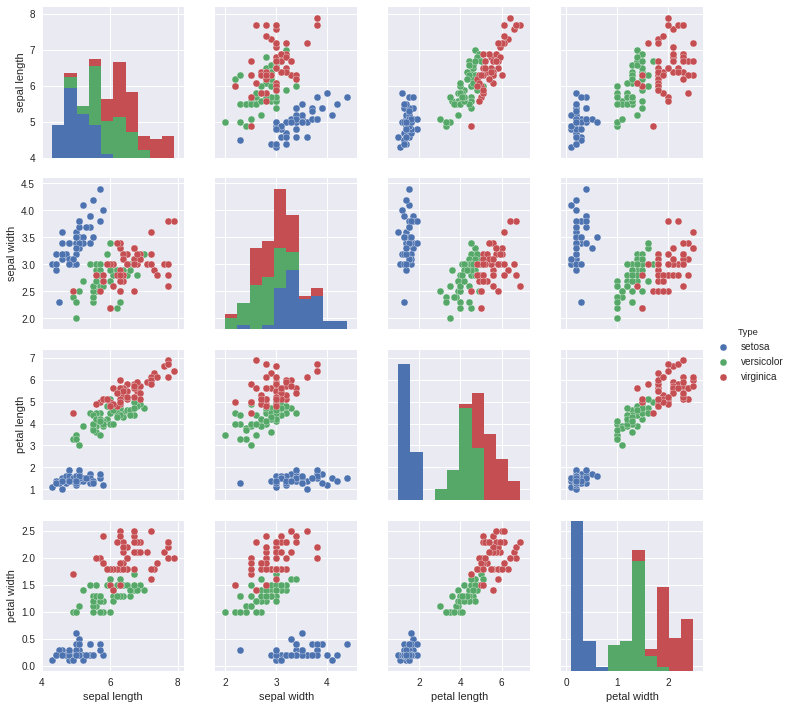

In [5]:
sns.pairplot(iris, hue="Type", diag_kind='hist')

## Fitting the model

Our task here is to predict the type of the iris based on its 4 features.

> **NOTE:** Starting with this example we will also apply the validation step. This means we fit the model on part of the data (called **train set**) and validate our model on the other part (called **test set**).

**Splitting the data**

In [ ]:
iris_train, iris_test = split(iris, train_size=0.7, 
                              random_state=12345)

**Defining the features and the target**

In [ ]:
X = iris_train.drop('Type', axis=1)
y = iris_train['Type']

**Fit the model**

In [ ]:
iris_clf = KNeighborsClassifier(n_neighbors=5).fit(X, y)

## Model assessment

**Apply the model**

In [11]:
iris_train['Type prediction'] = iris_clf.predict(X)
iris_train[::20]

,sepal length,sepal width,petal length,petal width,Type,Type prediction
78,6.0,2.9,4.5,1.5,versicolor,versicolor
95,5.7,3.0,4.2,1.2,versicolor,versicolor
46,5.1,3.8,1.6,0.2,setosa,setosa
140,6.7,3.1,5.6,2.4,virginica,virginica
138,6.0,3.0,4.8,1.8,virginica,virginica
34,4.9,3.1,1.5,0.1,setosa,setosa


**Evaluate the performance**

In [12]:
cm = confusion_matrix(y_true=iris_train['Type'],
                      y_pred=iris_train['Type prediction'])
pd.DataFrame(cm,
             index=iris_clf.classes_,
             columns=iris_clf.classes_)

,setosa,versicolor,virginica
setosa,34,0,0
versicolor,0,31,2
virginica,0,3,35


In [13]:
print classification_report(y_true=iris_train['Type'],
                            y_pred=iris_train['Type prediction'])

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        34
 versicolor       0.91      0.94      0.93        33
  virginica       0.95      0.92      0.93        38

avg / total       0.95      0.95      0.95       105



## Model validation

The model is validated if its predictions for the test set have the same quality as its predictions for the train set. This ensures that the model was not **overfitted** to the train data.

In [ ]:
X = iris_test.drop('Type', axis=1)
iris_test['Type prediction'] = iris_clf.predict(X)

In [15]:
iris_test.head()

,sepal length,sepal width,petal length,petal width,Type,Type prediction
69,5.6,2.5,3.9,1.1,versicolor,versicolor
42,4.4,3.2,1.3,0.2,setosa,setosa
56,6.3,3.3,4.7,1.6,versicolor,versicolor
35,5.0,3.2,1.2,0.2,setosa,setosa
16,5.4,3.9,1.3,0.4,setosa,setosa


In [16]:
cm = confusion_matrix(y_true=iris_test['Type'],
                      y_pred=iris_test['Type prediction'])
pd.DataFrame(cm,
             index=iris_clf.classes_,
             columns=iris_clf.classes_)

,setosa,versicolor,virginica
setosa,16,0,0
versicolor,0,16,1
virginica,0,0,12


# Metrics, distances and similarities

## The metric concept

The kNN algorithm looks for the k **nearest** neighbors, but what does that mean exactly? What is the **distance** between two data points?

The answer is that  the distance between data points is defined by a special function called [**metric**][metric], which is a hyperparameter of the classifier. There are many types of metrics and using the right one may have a significant impact on the classification result. To understand the idea of the metric concept, we will start our discussion by considering two points in the real-world (mathematically called [Euclidean space][eucspa]).

[metric]: https://en.wikipedia.org/wiki/Metric_(mathematics) "Metric - Wikipedia"
[eucspa]: https://en.wikipedia.org/wiki/Euclidean_space "Euclidean space - Wikipedia"

What is the **distance** between the points $A(1, 2)$ and $B(4, 6)$?

In [ ]:
A = [1, 2]
B = [4, 6]

x, y = zip(A, B)

Text(0,0.5,u'y')

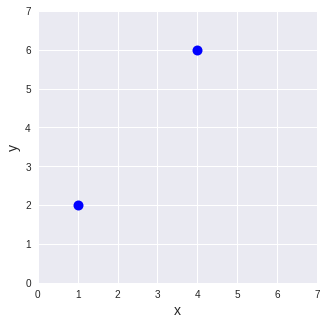

In [18]:
plt.figure(figsize=(5,5))
plt.plot(x, y, '.b', markersize=20)
plt.axis([0, 7, 0, 7])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

**The answer depends on what to you call distance...**

If we are allowed to go directly from $A$ to $B$, then we may consider the [Euclidean distance][l2] (called and symbolized $L_2$), which is given by:
<center>$d_{euclidean}(A,B)=\sqrt{(4-1)^2+(6-2)^2}=5$, </center>

[l2]: https://en.wikipedia.org/wiki/Euclidean_distance "Euclidean destance - Wikipedia"

[0, 7, 0, 7]

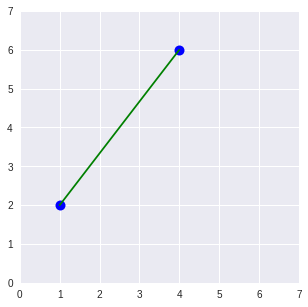

In [19]:
plt.figure(figsize=(5,5))
plt.plot(x, y, '.b', markersize=20)
plt.plot(x, y, '-g')
plt.axis([0, 7, 0, 7])

But if, on the other hand, we are taxi drivers in Manhattan, then we may drive only on the horizontal and vertical streets, and then we may consider what is called the [Manhattan (or taxicab) distance][l1] (symbolized as $L_1$), which is given by:
<center>$d_{manhattan}(A,B)=\lvert 4-1 \rvert+ \lvert 6-2 \rvert=7$</center>

[l1]: https://en.wikipedia.org/wiki/Taxicab_geometry "Taxicab geometry - Wikipedia"

[0, 7, 0, 7]

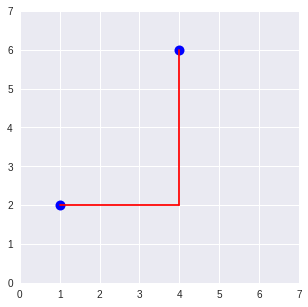

In [20]:
plt.figure(figsize=(5,5))
plt.plot(x, y, '.b', markersize=20)
plt.plot(x, [y[0], y[0]], '-r', [x[1], x[1]], y, '-r')
plt.axis([0, 7, 0, 7])

These two metrics are the most simple and common metrics, but as we will see soon there are others.

> **NOTE 1:** Intuitively, two of the basic properties of any distance are that (1) the distance between a data point and itself is 0, and (2) it should increase when the data points are more distant from each other.

> **NOTE 2:** The term "metric" has a very specific mathematical definition. Some of the "metrics" we will see are not proper metrics, but they serve for the same purpose. This is why we will use other terms like "similarity", "index", "linkage", "affinity" and others. We will not cover the exact definition of each one of them in this course.

> **NOTE 3:** The word "metric" is very common in the business world as a synonym for "measure". Be careful when using this term around people who may not be aware of the other meaning.

## Metrics examples

Let's explore some of the most common metrics by understanding the distances they return for three points in the Euclidean space. For the illustration we apply the function _pairwise_\__distances(X, metric)_, which returns all the distances between the points in a form called **distance matrix**.

Text(7,1,u'C')

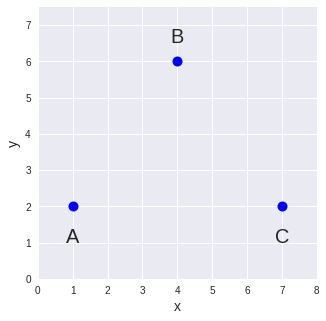

In [21]:
A = [1, 2]
B = [4, 6]
C = [7, 2]
x, y = zip(A, B, C)
X = np.array([A, B, C])

plt.figure(figsize=(5,5))
plt.plot(x, y, '.b', markersize=20)
plt.axis([0, 8, 0, 7.5])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.text(1, 1, 'A', fontsize=20, ha='center')
plt.text(4, 6.5, 'B', fontsize=20, ha='center')
plt.text(7, 1, 'C', fontsize=20, ha='center')

### Euclidean distance

In [22]:
dists = pairwise_distances(X, metric='euclidean')
pd.DataFrame(dists, 
             index=['A', 'B', 'C'], 
             columns=['A', 'B', 'C'])

,A,B,C
A,0.0,5.0,6.0
B,5.0,0.0,5.0
C,6.0,5.0,0.0


### Manhattan distance

In [23]:
dists = pairwise_distances(X, metric='manhattan')
pd.DataFrame(dists, 
             index=['A', 'B', 'C'], 
             columns=['A', 'B', 'C'])

,A,B,C
A,0.0,7.0,6.0
B,7.0,0.0,7.0
C,6.0,7.0,0.0


### Hamming distance

[Hamming distance][ham] returns the ratio of the non-identical features between the compared data points.

[ham]: https://en.wikipedia.org/wiki/Hamming_distance "Hamming distance - Wikipedia"

In [24]:
dists = pairwise_distances(X, metric='hamming')
pd.DataFrame(dists, 
             index=['A', 'B', 'C'], 
             columns=['A', 'B', 'C'])

,A,B,C
A,0.0,1.0,0.5
B,1.0,0.0,1.0
C,0.5,1.0,0.0


> **NOTE:** Hamming distance is a very common metric in various fields (e.g. communication, text mining), but it has many variations. Be careful to use the right one.

### Cosine distance

[Cosine **similarity**][cosine] is a measure of similarity between two points that measures the cosine of the angle between them, when the origin is the reference. It is thus a judgment of **orientation** and not magnitude. Cosine **distance** is derived from the similarity (distance = 1 - similarity), but it is not a proper metric. The cosine distance is very useful when there are many features (high-dimensional data), and also when the data is sparse. As we will see later in the course, this metric is commonly used today in recommender sysems and in NLP.

[cosine]: https://en.wikipedia.org/wiki/Cosine_similarity "Cosine similarity - Wikipedia"

In [25]:
dists = pairwise_distances(X, metric='cosine')
pd.DataFrame(dists, 
             index=['A', 'B', 'C'], 
             columns=['A', 'B', 'C'])

,A,B,C
A,0.000000,0.007722,0.324275
B,0.007722,0.000000,0.238061
C,0.324275,0.238061,0.000000


### User-defined metric

As we will see later, it is sometimes useful to define our own business-specific metric. This can be applied by simply write a "metric" function and send it to _pairwise_\__distances()_. For example, the following "metric" allows me to tune the importances of the differences in the x- and y-axes.

In [ ]:
def my_distance(rec1, rec2):
    x_diff = abs(rec1[0]-rec2[0])
    y_diff = abs(rec1[1]-rec2[1])
    weights = [0.8, 0.2]
    return weights[0] * x_diff + weights[1] * y_diff

In [30]:
dists = pairwise_distances(X, metric=my_distance)
pd.DataFrame(dists, 
             index=['A', 'B', 'C'], 
             columns=['A', 'B', 'C'])

,A,B,C
A,0.0,3.2,4.8
B,3.2,0.0,3.2
C,4.8,3.2,0.0


# Example

In this example we will demonstrate how to classify the appartments to cities based on the other features.

## Get the data

In [31]:
if 'google.colab' in modules:
    from google.colab import files
    uploaded = files.upload()

Saving prices.csv to prices.csv


In [32]:
prices = pd.read_csv("prices.csv", index_col='id')
prices.head()

,City,Balcony,Parking,Rooms,Air.Conditioner,Price
id,,,,,,
1,Haifa,None,Outside,3,None,3171
2,Tel Aviv,Balcony,Inside,2,A/C,4238
3,Haifa,None,None,3,None,2853
4,Jerusalem,None,None,2,None,2666
5,Tel Aviv,Balcony,None,3,None,4821


For technical reasons the categorical features have to be "encoded" as integers.

In [33]:
le = LabelEncoder()
encoded_features = prices[prices.columns[1:-1]].apply(le.fit_transform)
prices.update(encoded_features)
prices.head()

,City,Balcony,Parking,Rooms,Air.Conditioner,Price
id,,,,,,
1,Haifa,1,2,1,1,3171
2,Tel Aviv,0,0,0,0,4238
3,Haifa,1,1,1,1,2853
4,Jerusalem,1,1,0,1,2666
5,Tel Aviv,0,1,1,1,4821


## Define the "business" metric

To know how "similar" are the appartments considering their features we have to define our very own "metric". The target column (City) is obviously omitted from the distance calculation.

In [ ]:
features = ['Balcony', 'Parking', 'Rooms', 'Air.Conditioner', 'Price']

In [ ]:
def d_appartments(a, b):
    return sum([a[i] != b[i] for i in [0, 1, 2, 3]] + 
               [1 - float(min(a[4], b[4]))/max(a[4], b[4])])

### Illustration

We start by evaluating the distance matrix of our new metric.

> **NOTE:** This may take a while...

In [36]:
prices[:7]

,City,Balcony,Parking,Rooms,Air.Conditioner,Price
id,,,,,,
1,Haifa,1,2,1,1,3171
2,Tel Aviv,0,0,0,0,4238
3,Haifa,1,1,1,1,2853
4,Jerusalem,1,1,0,1,2666
5,Tel Aviv,0,1,1,1,4821
6,Tel Aviv,1,0,3,0,6386
7,Jerusalem,0,2,1,0,4873


In [37]:
distance_matrix = pairwise_distances(prices.loc[:, features], 
                                     metric=d_appartments)
dm = pd.DataFrame(distance_matrix,
                  index=prices.index,
                  columns=prices.index)
dm.iloc[:7, :7]

id,1,2,3,4,5,6,7
id,,,,,,,
1,0.000000,4.251770,1.100284,2.159256,2.342253,3.503445,2.349271
2,4.251770,0.000000,4.326805,3.370930,3.120929,2.336361,2.130310
3,1.100284,4.326805,0.000000,1.065545,1.408214,3.553241,3.414529
4,2.159256,3.370930,1.065545,0.000000,2.447003,3.582524,4.452904
5,2.342253,3.120929,1.408214,2.447003,0.000000,4.245067,2.010671
6,3.503445,2.336361,3.553241,3.582524,4.245067,0.000000,3.236925
7,2.349271,2.130310,3.414529,4.452904,2.010671,3.236925,0.000000


Now for a given appartment (i) we can find the appartments that are most similar to it.

In [38]:
i = 1234
similar = dm[dm[i] < 0.1].index.values
prices.loc[similar, :]

,City,Balcony,Parking,Rooms,Air.Conditioner,Price
id,,,,,,
164,Tel Aviv,1,2,0,1,3465
190,Tel Aviv,1,2,0,1,3508
461,Tel Aviv,1,2,0,1,3560
527,Tel Aviv,1,2,0,1,3796
715,Tel Aviv,1,2,0,1,3499
901,Tel Aviv,1,2,0,1,3580
1167,Tel Aviv,1,2,0,1,3496
1234,Tel Aviv,1,2,0,1,3601


## Classification using our metric

**Split the data**

In [ ]:
prices_train, prices_test = split(prices, train_size=0.7, 
                                  random_state=1729)

**Defining the features and the target**

In [ ]:
X = prices_train[features]
y = prices_train['City']

**Fit the model**

In [42]:
city_clf = KNeighborsClassifier(n_neighbors=5, 
                                metric=d_appartments)

city_clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function d_appartments at 0x7f81e7cf00c8>,
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## Model assessment

**Apply the model**

In [43]:
prices_train['City pred'] = city_clf.predict(X)
prices_train.head()

,City,Balcony,Parking,Rooms,Air.Conditioner,Price,City pred
id,,,,,,,
1086,Haifa,1,2,0,0,2433,Haifa
549,Tel Aviv,0,0,2,0,5987,Tel Aviv
1028,Tel Aviv,0,0,3,0,6877,Tel Aviv
144,Haifa,0,1,1,1,3520,Jerusalem
1229,Tel Aviv,1,0,3,0,6646,Tel Aviv


> **NOTE:** The distance calculation is performed only during the prediction stage (_fit()_ does nothing in the kNN classifier), and this is why it takes time.

**Evaluate the performance**

In [44]:
cm = confusion_matrix(y_true=prices_train.City,
                       y_pred=prices_train['City pred'])
pd.DataFrame(cm, 
             index=city_clf.classes_, 
             columns=city_clf.classes_)

,Haifa,Jerusalem,Tel Aviv
Haifa,295,3,0
Jerusalem,2,279,5
Tel Aviv,0,5,274


In [45]:
print classification_report(y_true=prices_train.City,
                            y_pred=prices_train['City pred'])

             precision    recall  f1-score   support

      Haifa       0.99      0.99      0.99       298
  Jerusalem       0.97      0.98      0.97       286
   Tel Aviv       0.98      0.98      0.98       279

avg / total       0.98      0.98      0.98       863



## Model validation

In [46]:
X = prices_test[features]
y = prices_test['City']

prices_test['City pred'] = city_clf.predict(X)
prices_test.head()

,City,Balcony,Parking,Rooms,Air.Conditioner,Price,City pred
id,,,,,,,
537,Tel Aviv,0,1,3,1,6273,Tel Aviv
664,Tel Aviv,1,2,0,0,3967,Tel Aviv
730,Tel Aviv,1,1,1,1,4657,Jerusalem
620,Tel Aviv,1,0,2,1,5647,Tel Aviv
755,Tel Aviv,1,2,3,1,6274,Tel Aviv


In [47]:
cm = confusion_matrix(y_true=prices_test.City,
                       y_pred=prices_test['City pred'])
pd.DataFrame(cm, 
             index=city_clf.classes_, 
             columns=city_clf.classes_)

,Haifa,Jerusalem,Tel Aviv
Haifa,114,9,0
Jerusalem,2,111,7
Tel Aviv,0,15,113


In [48]:
print classification_report(y_true=prices_test.City,
                            y_pred=prices_test['City pred'])

             precision    recall  f1-score   support

      Haifa       0.98      0.93      0.95       123
  Jerusalem       0.82      0.93      0.87       120
   Tel Aviv       0.94      0.88      0.91       128

avg / total       0.92      0.91      0.91       371



## Classification using Euclidean metric

Let's see what happens if we try to classify the data with the "intuitive" Euclidean metric.

**Fit**

In [49]:
city_clf = KNeighborsClassifier(n_neighbors=5, 
                                metric='euclidean')
X = prices.loc[:, features]
y = prices['City']

city_clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

**Predict**

In [50]:
prices['City pred'] = city_clf.predict(X)
prices.head()

,City,Balcony,Parking,Rooms,Air.Conditioner,Price,City pred
id,,,,,,,
1,Haifa,1,2,1,1,3171,Jerusalem
2,Tel Aviv,0,0,0,0,4238,Haifa
3,Haifa,1,1,1,1,2853,Haifa
4,Jerusalem,1,1,0,1,2666,Haifa
5,Tel Aviv,0,1,1,1,4821,Jerusalem


**Assess**

In [51]:
print confusion_matrix(y_true=prices.City,
                       y_pred=prices['City pred'],
                       labels=city_clf.classes_)
print classification_report(y_true=prices.City,
                            y_pred=prices['City pred'])

[[329  64  28]
 [114 228  64]
 [ 73  68 266]]
             precision    recall  f1-score   support

      Haifa       0.64      0.78      0.70       421
  Jerusalem       0.63      0.56      0.60       406
   Tel Aviv       0.74      0.65      0.70       407

avg / total       0.67      0.67      0.66      1234



**Validate**

Why bother...?